# Training a network against data from the Burgers equation

Training a Convolutional Neural Network (CNN) with data from the Burgers equation. See model_1d folder for the code that generated the data.

A simple setup for a surrogate model predicts the next time-step from the current one. This all starts from a mathematical model, which tyically involves Patial Differential Equations, but here we just collect the dynamic variables in the model in a vector $x$ at discrete times $t_0,t_1,\ldots,t_K$ and denote these as $x_k$. We can represent the numerical model as:

$x_{k+1}=M(x_k)$, starting with given initial condition $x_0$

Next, we run the numerical model and collect $x_0,x_1,\ldots,x_K$ as training data for our Machine Learning (ML) model. The aim of the ML model will be to approximate the numerical model, and we'll call it a surrogate model. It's main purpose is to have a faster but slightly less accurate version of the model. We denote the surrogate model as: 

$\hat{x}_{k+1}=\hat{M}(\hat{x}_k,\theta)$

starting with $\hat{x}_0=x_0$, which is the true initial condition.

This model has $\hat{x}_k$ as input and $x_{k+1}$ as output, and $\theta$ is a vector of parameters of the ML model to be estimated. For a given vector of parameters, one can sequentially compute $\hat{x}_1$, $\hat{x}_2$, $\hat{x}_3$, etc. This is called a rollout.

## Training

For training the most basic approach is to use one-step-ahead predictions. This means that the target is to accurately approximate the output of the numerical model. We can write this as a loss function:

$J(\theta) = \sum_{k=1}^{K-1} | x_{k+1} - \hat{M}(x_k,\theta)|^2$

Viewed as a supervised learning method, we have the generated data $x_k$ as inputs and $x_{k+1}$ as outputs. As is common in such cases the input data are collected in an input array $X$ and an output array $Y$ that consist of:

$X=[x_0,x_1,\ldots,x_{K-1}]$
$Y=[x_1,x_2,\ldots,x_{K}]$ 

We can generalize $\hat{M}$ to matrices to obtain:

$Y \approx \hat{M}(X,\theta)$

Unfortunately there is no guarantee that reasonably accurate one-step-ahead predictions lead to accurate rollouts, since the errors can accumulate quickly.


In [1]:
# Load Packages

# swithch to the directory where this script is located
cd(@__DIR__)

# Packages
using Pkg
Pkg.activate(".")
#Pkg.instantiate()
using Flux
using BSON
using Plots, Measures
using JLD2

# optional gpu usage
const use_gpu = false
if use_gpu
    using CUDA
end

  Activating project at `~/dellete/src/julia_ml_tests.jl.git/training_1d_flux`


In [2]:
# Load the data

input_file = joinpath("..", "model_1d", "burgers1d_periodic.jld2")
if !isfile(input_file)
    println("Data file not found: $input_file")
end
println("Loading data from $input_file")
data=load(input_file)

# Convert data to input and output arrays

n_times=length(data["solution"])
n_points=length(data["solution"][1])

# Create inputs X and outputs Y
# u is the solution, t is the time, x is the spatial coordinate
X = zeros(Float32,n_points,1,n_times-1) # Float32 for GPU compatibility, 1 channel since only one variable u
Y = zeros(Float32,n_points,1,n_times-1) 

for t in 1:n_times-1
    X[:,:,t] .= data["solution"][t]
    Y[:,:,t] .= data["solution"][t+1]
end

@show X, size(X)
@show Y, size(Y)

# some metadata for plotting
output_times = data["times"][2:end]
output_x = data["grid"]
x0= X[:,:,1] # initial condition for rollout
nsteps = length(output_times)
nothing

Loading data from ../model_1d/burgers1d_periodic.jld2
(X, size(X)) = (Float32[1.4990133; 1.4960574; 1.4911436; 1.4842916; 1.4755282; 1.4648882; 1.4524136; 1.4381534; 1.422164; 1.4045085; 1.3852566; 1.3644843; 1.3422736; 1.318712; 1.2938926; 1.2679133; 1.2408768; 1.2128897; 1.1840622; 1.1545085; 1.124345; 1.0936906; 1.0626667; 1.0313953; 1.0; 0.96860474; 0.9373334; 0.90630937; 0.87565506; 0.8454915; 0.8159377; 0.7871103; 0.75912315; 0.7320866; 0.7061074; 0.681288; 0.65772647; 0.6355157; 0.61474335; 0.5954915; 0.57783604; 0.5618467; 0.5475865; 0.5351118; 0.52447176; 0.51570845; 0.50885636; 0.50394267; 0.50098664; 0.5; 0.50098664; 0.50394267; 0.50885636; 0.51570845; 0.52447176; 0.5351118; 0.5475865; 0.5618467; 0.57783604; 0.5954915; 0.61474335; 0.6355157; 0.65772647; 0.681288; 0.7061074; 0.7320866; 0.75912315; 0.7871103; 0.8159377; 0.8454915; 0.87565506; 0.90630937; 0.9373334; 0.96860474; 1.0; 1.0313953; 1.0626667; 1.0936906; 1.124345; 1.1545085; 1.1840622; 1.2128897; 1.2408768; 1.2679133

In [3]:
# check for number of available samples
println("Number of times: $n_times")

Number of times: 51


In [31]:
# Settings

# training
n_epochs = 1000
batch_size = 40
learning_rate = 0.005
n_train = 40 # number of training samples, set to 1000 for faster training
n_val = 10 # number of validation samples, set to 100 for faster training
# check if we have enough data
n_samples = size(X, 3)
if n_train + n_val > n_samples
    error("n_train + n_val must be less than or equal to the number of samples: $n_samples")
end

# model
n_in = 1 # number of input channels (X)
n_out = 1 # number of output channels (Y)
n_hidden = 8 # number of hidden features in the model
#n_layers = 3 # number of hidden layers in the model
n_filter= 3 # width of the convolutional filter

3

In [32]:
# Split the data into training and validation sets
X_train_cpu = X[:,:,1:n_train]
Y_train_cpu = Y[:,:,1:n_train]
X_val_cpu = X[:,:,n_train+1:n_train+n_val]
Y_val_cpu = Y[:,:,n_train+1:n_train+n_val]
@show size(X_train_cpu), size(Y_train_cpu)
@show size(X_val_cpu), size(Y_val_cpu)

(size(X_train_cpu), size(Y_train_cpu)) = ((100, 1, 40), (100, 1, 40))
(size(X_val_cpu), size(Y_val_cpu)) = ((100, 1, 10), (100, 1, 10))


((100, 1, 10), (100, 1, 10))

In [33]:
# move data to gpu
if use_gpu
    X_train = gpu(X_train_cpu)
    Y_train = gpu(Y_train_cpu)
    X_val = gpu(X_val_cpu)
    Y_val = gpu(Y_val_cpu)
else
    X_train = X_train_cpu
    Y_train = Y_train_cpu
    X_val = X_val_cpu
    Y_val = Y_val_cpu
end

# create the data loaders
train_loader = Flux.DataLoader((X_train, Y_train), batchsize=min(batch_size,n_train), shuffle=true)

val_loader = Flux.DataLoader((X_val, Y_val), batchsize=min(batch_size,n_val), shuffle=false)

@show train_loader
@show val_loader
nothing

train_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, shuffle=true, batchsize=40)
val_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, batchsize=10)


In [55]:
# Create the model
n_pad=n_filter ÷ 2 # padding for the convolutional layer
PadCircular(x) = pad_circular(x, (n_pad,n_pad,0,0,0,0))

model_residual = Chain(
    PadCircular,
    Conv((n_filter,), n_in=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_out)
)

# Define the model with residual block
struct ResidualBlock
    f::Chain
end

# Define how the ResidualBlock works
(m::ResidualBlock)(x) = x + m.f(x)

# Allow Flux to recognize ResidualBlock as a layer
Flux.@layer ResidualBlock

# create the model with residual blocks
model_cpu = ResidualBlock(model_residual)

if use_gpu
    model = gpu(model_cpu)
else
    model = model_cpu
end

ResidualBlock(
  Chain(
    Main.PadCircular,
    Conv((3,), 1 => 8, swish),          # 32 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 1),                 # 25 parameters
  ),
)                   # Total: 8 arrays, 457 parameters, 2.387 KiB.

In [56]:
# Create loss function

mse_loss(model,x, y) = Flux.mse(model(x), y)

mse_loss (generic function with 1 method)

In [57]:

# Initialize the ADAM optimizer with default settings
optimizer = Flux.setup(Adam(learning_rate),model)

# Train the model
# and display the accuracy on each
# iteration
for epoch in 1:n_epochs
    # Train the model on the training data
    # and display the loss on eachiteration
	Flux.train!(mse_loss, model, train_loader, optimizer)
    println("epoch: $(epoch)") #NOTE: we careless with compute, rerunning model each time below
    println("   Loss for training    : $(mse_loss(model,X_train,Y_train))")
    println("   Loss for validation  : $(mse_loss(model,X_val,Y_val))")
end
     


epoch: 1
   Loss for training    : 0.00269001
   Loss for validation  : 0.0031249675
epoch: 2
   Loss for training    : 0.0007776983
   Loss for validation  : 0.0012422217
epoch: 3
   Loss for training    : 0.001152875
   Loss for validation  : 0.001597969
epoch: 4
   Loss for training    : 0.0016813319
   Loss for validation  : 0.002107836
epoch: 5
   Loss for training    : 0.0012806294
   Loss for validation  : 0.0017128912
epoch: 6
   Loss for training    : 0.00078830216
   Loss for validation  : 0.0012325373
epoch: 7
   Loss for training    : 0.00065289345
   Loss for validation  : 0.001104251
epoch: 8
   Loss for training    : 0.00079769717
   Loss for validation  : 0.0012503339
epoch: 9
   Loss for training    : 0.00096288155
   Loss for validation  : 0.0014140196
epoch: 10
   Loss for training    : 0.0009880065
   Loss for validation  : 0.0014371104
epoch: 11
   Loss for training    : 0.0008813394
   Loss for validation  : 0.0013279301
epoch: 12
   Loss for training    : 0.00073

Excessive output truncated after 524325 bytes.

   Loss for training    : 2.2430852e-6
   Loss for validation  : 1.4939336e-5
epoch: 933
   Loss for training    : 2.238056e-6
   Loss for validation  : 1.4912988e-5
epoch: 934
   Loss for training    : 2.2330257e-6
   Loss for validation  : 1.4886244e-5
epoch: 935


In [58]:
# unroll the model to get the output for the initial condition
function unroll(model, x0, nsteps)
    x = reshape(x0, size(x0, 1), size(x0, 2), 1) # ensure x0 is 3
    outputs = zeros(Float32, size(x0, 1), size(x0, 2), nsteps+1)
    outputs[:,:,1] .= x0 # store the initial condition
    # unroll the model for nstep
    for t in 1:nsteps
        x = model(x)
        outputs[:,:,t+1] .= x
    end
    return outputs
end

# unroll the model to get the output for the initial condition
Y_unroll = unroll(model, x0, nsteps)

nothing

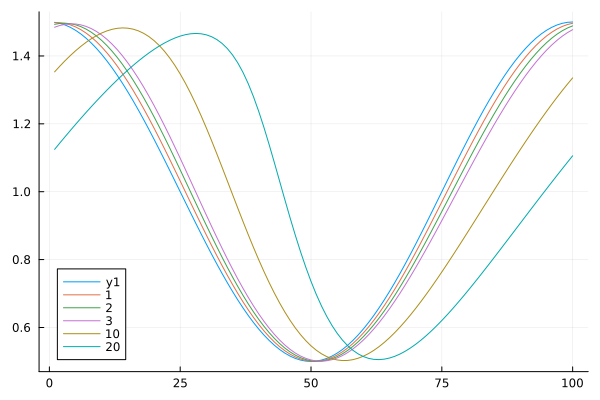

In [59]:
plot(Y_unroll[:,1,1],lavel="x0")
plot!(Y_unroll[:,1,2], label="1")
plot!(Y_unroll[:,1,3], label="2")
plot!(Y_unroll[:,1,4], label="3")
plot!(Y_unroll[:,1,11], label="10")
plot!(Y_unroll[:,1,21], label="20")

Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/training_1d_flux/burgers1d_periodic_ml_unroll.gif")
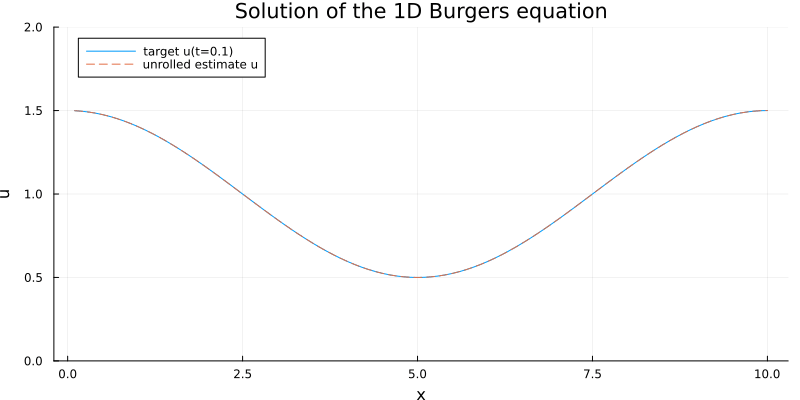

In [60]:
# Make movie of the unrolled output
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(output_times)
        p1 = plot(output_x, X[:,1,i], label="target u(t=$(round(output_times[i],digits=2)))", xlabel="x", ylabel="u", ylim=(0, 2))
        plot!(output_x, Y_unroll[:,1,i], label="unrolled estimate u", linestyle=:dash)
        plot(p1, size=(800,400), title="Solution of the 1D Burgers equation")
    end
    gif(anim, "burgers1d_periodic_ml_unroll.gif", fps=15)
end

In [61]:
@show model_cpu

ResidualBlock(
  Chain(
    Main.PadCircular,
    Conv((3,), 1 => 8, swish),          # 32 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 1),                 # 25 parameters
  ),
)                   # Total: 8 arrays, 457 parameters, 2.387 KiB.

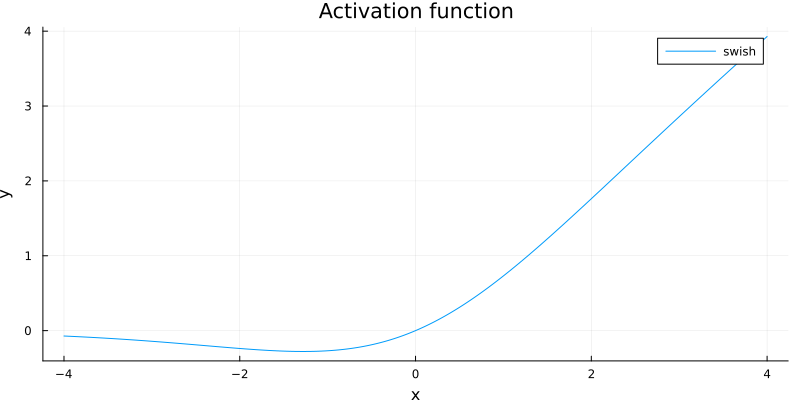

In [62]:
xx=-4:0.01:4
yy=Flux.swish.(xx)
plot(xx, yy, label="swish", xlabel="x", ylabel="y", 
     title="Activation function", size=(800,400), legend=:topright)